#縄文土器（胴部）クラスタ解析

## Voxelデータの展開


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/jomon/jomon/jomonvoxels-128-20240308.zip

In [ ]:
# body 除外の個体を削除
!rm data/voxel/rm0681* data/voxel/rm0943*

# パッケージインストール


In [ ]:
!pip install -q japanize_matplotlib
!pip install -q tensorflow-determinism classification-models-3D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 55.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 3.0 MB/s eta 0:00:00


# 仮ラベル付きのクラスタリング

In [ ]:
import os
from glob import glob
import re
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
import gc

from skimage.transform import resize
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:

def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


set_seed(123)


## 定数定義

In [ ]:
NUM_CLASSES = 4
NUM_CLUSTERS = 4
NUM_PCA_COMPONENTS = 4
BUFFER_SIZE = 1000
BATCH_SIZE = 4
EPOCHS = 60
CLUSTERING_INTERVAL = 3
DATA_DIR = '/content/data/voxel'
IMAGE_SIZE = 128
NUM_CHANNELS = 3
PART = "body"

FEATURE_EXTRACTOR_MODEL_PATH = "feature_extractor_20230308-128-swish-noise-single-random-IV3_JomonV7_{}_cls{}_ep{}.hdf5".format(PART, NUM_CLUSTERS,EPOCHS)
CLASSIFIER_MODEL_PATH = "classifier_20230308-128-swish-noise-single-random-IV3_JomonV7_{}_cls{}_ep{}.hdf5".format(PART, NUM_CLUSTERS,EPOCHS)
DATASET_SAVE_PATH = "pseudo_dataset_20230308-128-swish-noise-single-random-IV3_JomonV7_{}_cls{}_ep{}".format(PART, NUM_CLUSTERS,EPOCHS)

DATASAVE_DIR = "JomonV7_{}_20230308-128-swish-noise-single-random-IV3_deg30_cls{}_ep{}".format(PART, NUM_CLUSTERS,EPOCHS)


## モデル定義

In [ ]:
class ConvNet3D(keras.Model):
    def __init__(self):
        super(ConvNet3D, self).__init__()
        self.conv3d_1 = keras.layers.Conv3D(filters=64,
                                            padding='same', kernel_size=3, activation='linear', name='conv3d_1')
        self.bn_1 = keras.layers.BatchNormalization()
        self.act_1 = keras.layers.Activation('swish')
        self.maxpool3d_1 = keras.layers.MaxPool3D(pool_size=2)


        self.conv3d_2 = keras.layers.Conv3D(filters=64,
                                            padding='same', kernel_size=3, activation='linear', name='conv3d_2')
        self.bn_2 = keras.layers.BatchNormalization()
        self.act_2 = keras.layers.Activation('swish')
        self.maxpool3d_2 = keras.layers.MaxPool3D(pool_size=2)


        self.conv3d_3 = keras.layers.Conv3D(filters=128,
                                            padding='same',  kernel_size=3, activation='linear', name='conv3d_3')
        self.bn_3 = keras.layers.BatchNormalization()
        self.act_3 = keras.layers.Activation('swish')
        self.maxpool3d_3 = keras.layers.MaxPool3D(pool_size=2)


        self.conv3d_4 = keras.layers.Conv3D(filters=256,
                                            padding='same', kernel_size=3, activation='linear', name='conv3d_4')
        self.bn_4 = keras.layers.BatchNormalization()
        self.act_4 = keras.layers.Activation('swish')
        self.maxpool3d_4 = keras.layers.MaxPool3D(pool_size=1)


        self.gap_1 = keras.layers.GlobalAveragePooling3D()

        self.dense_1 = keras.layers.Dense(128)

    def call(self, inputs):
        x = self.conv3d_1(inputs)
        x = self.bn_1(x)
        x = self.act_1(x)
        x = self.maxpool3d_1(x)

        x = self.conv3d_2(x)
        x = self.bn_2(x)
        x = self.act_2(x)
        x = self.maxpool3d_2(x)

        x = self.conv3d_3(x)
        x = self.bn_3(x)
        x = self.act_3(x)
        x = self.maxpool3d_3(x)

        x = self.conv3d_4(x)
        x = self.bn_4(x)
        x = self.act_4(x)
        x = self.maxpool3d_4(x)

        x = self.gap_1(x)
        x = self.dense_1(x)
        return x

In [ ]:
class Classify3D(tf.keras.Model):
    def __init__(self, feature_extractor, num_of_classes=3):
        super(Classify3D, self).__init__()
        self.feature_extractor = feature_extractor
        self.num_of_classes = num_of_classes
        self.activation_1 = keras.layers.Activation(keras.activations.selu)
        self.dense_1 = keras.layers.Dense(self.num_of_classes, activation='softmax')

    def call(self, inputs):
        x = self.feature_extractor(inputs)
        x = self.activation_1(x)
        x = self.dense_1(x)

        return x

In [ ]:
feature_extractor = ConvNet3D()
feature_extractor.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
feature_extractor.summary()

Model: "conv_net3d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_1 (Conv3D)           multiple                  5248      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling3d (MaxPooling3  multiple                  0         
 D)                                                              
                                                                 
 conv3d_2 (Conv3D)           multiple                  110656    
                                                                 
 batch_normalization_1 (Bat  multiple                  2

In [ ]:
classifier = Classify3D(feature_extractor, num_of_classes=NUM_CLASSES)
classifier.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
classifier.summary()

Model: "classify3d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_net3d (ConvNet3D)      multiple                  1257152   
                                                                 
 activation_4 (Activation)   multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  516       
                                                                 
Total params: 1257668 (4.80 MB)
Trainable params: 1256644 (4.79 MB)
Non-trainable params: 1024 (4.00 KB)
_________________________________________________________________


In [ ]:
pca = PCA(n_components=NUM_PCA_COMPONENTS)

stdsc = StandardScaler()

kmc = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', n_init=2, max_iter=300,
                       tol=0.0001, verbose=0, random_state=123, copy_x=True)

## データ準備

In [ ]:
train_pattern = DATA_DIR +'/rm*_{}_*_{}.npy'.format(IMAGE_SIZE, PART)

train_list_ds = tf.data.Dataset.list_files(train_pattern, shuffle=False)

# 学習中の混同行列表示用に正解ラベルを格納する（推論モードから入りラベルを変更するためモデルは読み込まない）
# 今回は全て0を入れる
train_ids = list(np.zeros(len(train_list_ds)))

train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_ids, tf.int64))

In [ ]:
def read_npy_file(path):
    voxel_data = np.load(path.numpy())
    #RGBAが全て0ならばランダム値をいれてAチャネルを切る
    data = np.where(np.all(voxel_data, axis=3, keepdims=True) ==0, np.random.randint(0, 256,(IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE,4)), voxel_data)[:,:,:,0:3]/255
    return tf.convert_to_tensor(data, dtype=tf.float32)

In [ ]:
train_3d_ds = train_list_ds.map(
        lambda item: tf.py_function(read_npy_file, [item], tf.float32))#.cache(filename='./cache.tf-data')

## モデルの学習

In [ ]:
!nvidia-smi

Sun Mar 10 23:55:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              53W / 400W |    455MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.optimizers.Adam(learning_rate=1.0e-4)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')


for epoch in range(EPOCHS):
    if epoch % CLUSTERING_INTERVAL == 0:
        features_list= [feature_extractor(batch_x, training=False) \
                         for batch_x in train_3d_ds.batch(BATCH_SIZE).prefetch(1)]


        #分類クラスタリング
        features = np.vstack([rslt for rslt in features_list])
        #PCA
        features_pca = pca.fit_transform(features)
        #PCA後標準化
        features_std = stdsc.fit_transform(features_pca)
        km_predictions = kmc.fit_predict(features_std)
        cluster_matrix = np.zeros((NUM_CLASSES, NUM_CLUSTERS), dtype=np.int32)

        for i, cat_id in enumerate(train_label_ds.batch(BATCH_SIZE)):
          for true, kmp in zip(cat_id,km_predictions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]):
            cluster_matrix[true, kmp] += 1

        print("Epoch: {}, Distortion: {:.2f}".format(epoch, kmc.inertia_))
        print(cluster_matrix)

        #仮ラベルのデータセット
        pseudo_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(\
                                                  np.array(km_predictions).T, tf.int64))
        #仮ラベルの学習データセット
        train_dataset = tf.data.Dataset.zip((train_3d_ds, pseudo_label_ds)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:

            y = classifier(x_batch_train, training=True)
            loss = loss_fn(y_batch_train, y)

        grads = tape.gradient(loss, classifier.trainable_weights)
        optimizer.apply_gradients(zip(grads, classifier.trainable_weights))

        train_loss(loss)
        train_accuracy(y_batch_train, y)



    template = 'Epoch {}, Loss: {}, Accuracy: {}'


    print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100))
    #reset0
    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch: 0, Distortion: 1000.43
[[ 95 176 126  71]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]


Epoch 1, Loss: 0.8696236610412598, Accuracy: 63.88888931274414
Epoch 2, Loss: 0.5832920074462891, Accuracy: 77.56410217285156
Epoch 3, Loss: 0.5193639993667603, Accuracy: 80.34188079833984
Epoch: 3, Distortion: 945.24
[[ 59  96 204 109]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Epoch 4, Loss: 0.9830902814865112, Accuracy: 66.23931884765625
Epoch 5, Loss: 0.4838554859161377, Accuracy: 82.69230651855469
Epoch 6, Loss: 0.4404628276824951, Accuracy: 85.04273223876953
Epoch: 6, Distortion: 868.40
[[ 47 217 120  84]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Epoch 7, Loss: 1.0047086477279663, Accuracy: 63.88888931274414
Epoch 8, Loss: 0.5310909748077393, Accuracy: 79.9145278930664
Epoch 9, Loss: 0.37143200635910034, Accuracy: 87.82051086425781
Epoch: 9, Distortion: 767.79
[[ 48 216 120  84]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Epoch 10, Loss: 0.3204714059829712, Accuracy: 90.17093658447266
Epoch 11, Loss: 0.25510767102241516, Accuracy: 90.5

## 仮ラベル付きのデータセットとモデルを保存する
 ・データのパスと仮ラベルの組合せのデータセットを保存

In [ ]:
tf.data.experimental.save(tf.data.Dataset.zip((train_list_ds, pseudo_label_ds)), DATASET_SAVE_PATH)
tf.data.experimental.save(tf.data.Dataset.zip((train_list_ds, train_label_ds)), DATASET_SAVE_PATH+"-inital")

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [ ]:
#データセットの読み込み用
pseudo_dataset = tf.data.experimental.load(DATASET_SAVE_PATH)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [ ]:
feature_extractor.save_weights(FEATURE_EXTRACTOR_MODEL_PATH)
classifier.save_weights(CLASSIFIER_MODEL_PATH)

## 学習済みモデルを使用したクラスタリング

In [ ]:
features_list = [feature_extractor(batch, training=False) for batch in train_3d_ds.batch(BATCH_SIZE)]

features = np.vstack([rslt for rslt in features_list])

features_pca = pca.fit_transform(features)
features_std = stdsc.fit_transform(features_pca)

km_predictions = kmc.fit_predict(features_std)


np.save('features.npy', features)
np.save('features_pca.npy', features_pca)
np.save('features_std.npy', features_std)
np.save('km_predictions.npy', km_predictions)

In [ ]:
##ドライブへ一時退避
!mkdir /content/drive/MyDrive/jomon/jomon/{DATASAVE_DIR}
!cp -r *.npy {FEATURE_EXTRACTOR_MODEL_PATH} {CLASSIFIER_MODEL_PATH} {DATASET_SAVE_PATH} {DATASET_SAVE_PATH}-inital /content/drive/MyDrive/jomon/jomon/{DATASAVE_DIR}

In [ ]:
!cp -r /content/drive/MyDrive/jomon/jomon/{DATASAVE_DIR} ./

In [ ]:
num = []
name = []
pseudo_id = []
cluster_id = []
initial_id = []



for i, d in enumerate(pseudo_dataset):
  name.append(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',2)[0])
  pseudo_id.append(d[1].numpy())
  num.append(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',2)[2])

for k in km_predictions:
  cluster_id.append(k)

for i in train_label_ds:
  initial_id.append(i.numpy())


pseudo_df = pd.DataFrame(list(zip(name, num, \
                                  initial_id, \
                                  pseudo_id, cluster_id)), columns = \
                  ['列品番号','回転角度',\
                   '初期ラベル-ID',\
                   '疑似ラベル-ID','クラスタ-ID'])
pseudo_df.to_csv(DATASET_SAVE_PATH+".csv")

In [ ]:
gc.collect()

267

## クラスタ可視化

### plot用のラベル

In [ ]:
pseudo_dataset = tf.data.experimental.load(DATASET_SAVE_PATH)

In [ ]:
cc_re = re.compile(r'.+/(.+?)_[0-9]+_[0-9]+_(.+?).npy')
name_list = [ cc_re.match(item.numpy().decode())[1]+"_"+cc_re.match(item.numpy().decode())[2] for item, label in pseudo_dataset]

### PCA

In [ ]:

tsne = TSNE(n_components=2, random_state=0, init='pca')
projections = tsne.fit_transform(features_std)

x = projections[:,0]
y = projections[:,1]
color = km_predictions
symbol = km_predictions
df = pd.DataFrame({'x':x,'y':y, 'name':name_list,'クラスタ':np.array(color, dtype='str')})

df_s = df.sort_values(by='クラスタ', ascending=True)


fig = px.scatter(
    df_s.loc[:,["x","y"]].values, x=0, y=1,
    color=df_s.loc[:,"クラスタ"].values,
    symbol=df_s.loc[:,"クラスタ"].values,
    labels={'color': 'Categories'},
    title='PCA後標準化-縄文土器',
    text=df_s.loc[:,"name"],
    width=1000, height=1000,
    size_max=10,
    size=np.full(len(km_predictions), 10),
)


fig.update_layout(
    legend_title="クラスタ",
    font=dict(
        family="Courier New, monospace",
        size=14,
    )
)
fig.show()
fig.write_html("pca_std_type.html")

In [ ]:
# 縦軸回転拡張データ無し版
true_labels_df = pd.read_excel("/content/drive/MyDrive/jomon/true_labels_dataset_JomonV7.xlsx")

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(features_std)

x = projections[:,0]
y = projections[:,1]
color = km_predictions
symbol = km_predictions
df = pd.DataFrame({'x':x,'y':y, 'name':true_labels_df["列品番号"], "labels":true_labels_df["系統型式"],"angle":true_labels_df["回転角度"],'クラスタ':np.array(color, dtype='str')})

df_s = df.sort_values(by='クラスタ', ascending=True)

df_s = df_s[df_s['angle'].str.startswith('000')]

fig = px.scatter(
    df_s.loc[:,["x","y"]].values, x=0, y=1,
    color=df_s.loc[:,"クラスタ"].values,
    symbol=df_s.loc[:,"クラスタ"].values,
    labels={'color': 'Categories', 'symbol': 'Categories'},
    title='PCA(標準化)-縄文土器',
    text=df_s.loc[:,"labels"]+"("+df_s.loc[:,"name"]+")",
    width=1000, height=1000,
    size_max=15,
    size=np.full(len(km_predictions[::12]), 15),
)


fig.update_layout(
    legend_title="クラスタ",
    legend= {'itemsizing': 'constant'},
    font=dict(
        family="Courier New, monospace",
        size=20,
    )
)
for trace in fig.data:
    trace.marker.size = 15

fig.show()
fig.write_html("JomonV7_000_pca_std_type_3.html")

### エルボー法の適用

In [ ]:
inertias1 = []
for k in range(2,16):
    kmc = KMeans(n_clusters=k, init='k-means++', n_init=16, max_iter=300,
                           tol=0.0001, verbose=0, random_state=None, copy_x=True)

    km_predictions1_e = kmc.fit_predict(features_std)
    inertias1.append(kmc.inertia_)

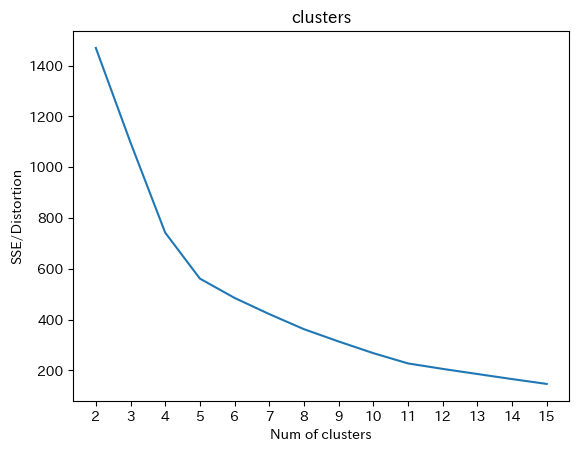

In [ ]:
plt.plot(range(2,16), inertias1, '-')
plt.xticks(range(2,16))
plt.title("clusters")
plt.xlabel('Num of clusters')
plt.ylabel('SSE/Distortion')
plt.savefig('elbow_chart.png')

### グラフなどを保存する

In [ ]:
!mkdir {DATASAVE_DIR}
!cp -r *.png *.npy *.html *.hdf5 *.csv {DATASET_SAVE_PATH} {DATASET_SAVE_PATH}-inital {DATASAVE_DIR}
!zip -r {DATASAVE_DIR}.zip {DATASAVE_DIR}

In [ ]:
!mv {DATASAVE_DIR}.zip /content/drive/MyDrive/jomon/jomon